# Introduction

Using the development version of [scikit-learn](http://scikit-learn.org/dev/documentation.html), we construct a neural network (NN) regression model to map from a quantum mechanical potential to the energy levels (eigenvalues) for the single-particle system. The potential $V(x)$ is defined in the range $x\in [-1,1]$ and has the boundary conditions $V(\pm 1) = \infty$. The primary purpose of this notebook is to determine the optimal parameters of the NN. We do this using $10^4$ training examples. We train using these parameters. 

The potentials used for training and testing are generated in [potentials.ipynb](potentials.ipynb). The eigenvalues for all potentials are calculated in [eigenvalues.ipynb](eigenvalues.ipynb).

Documentation for `sklearn`'s supervised NN tools can be found here: http://scikit-learn.org/dev/modules/neural_networks_supervised.html. While already quite good, this documentation still appears to be "under construction".

# Preliminaries

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
import time

In [2]:
# Number of basis states for the wavefunctions
NBW = 50
nbws = np.arange(1, NBW+1)
# Number of potentials:
NV = int(1E5)
# Number of basis states in the potential:
NB = 10
ns = np.arange(1, NB+1)
# lambda (variance of Legendre coefficients):
lam = 0.75
# The variance of the n=0 legendre coefficient V_0:
V20 = 10

# Input file:
filepath = "../Data/eigenvalues_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
filepathSD = "../Data/eigenvaluesSD_NV" + str(NV) \
    + "_NB" + str(NB) + "_lam" \
    + str(lam) + "_V20" + str(V20) + ".npy"
data = np.load(filepath)
dataSD = np.load(filepathSD)
VSns = data[::,0:10]
VCns = data[::,10:20]
eigs = data[::,20::]

# We define functios that help us map the Fourier-space potentials into coordinate space.
def VS(ns, xs):
    return np.sin(np.pi*np.outer(ns,xs))
def VC(ns, xs):
    return np.cos(np.pi*np.outer(ns,xs))

In [3]:
print("Data shape: ", data.shape, 
      "\nSine coefficients shape: ", VSns.shape,
      "\nCosine coefficients shape: ", VCns.shape, eigs.shape,
      "\nStd. dev. shape: ", dataSD.shape
     )

Data shape:  (100000, 60) 
Sine coefficients shape:  (100000, 10) 
Cosine coefficients shape:  (100000, 10) (100000, 40) 
Std. dev. shape:  (40,)


# Preprocessing

In [4]:
# Number of x coordinates:
Nx = 100
xs = np.linspace(-1,1,Nx)

# The coordinate space potentials:
VSs = VS(ns,xs)
VCs = VC(ns,xs)
Vgrid = np.dot(VSns,VSs) + np.dot(VCns,VCs)
VgridFlipped = np.dot(-VSns,VSs) + np.dot(VCns,VCs)

# Make sure the flip worked by looking at a random potential:
rint = randint(0, NV)
print("First 4 values of Vgrid[" +
      str(rint) + 
      "]:" , Vgrid[rint][0:4])
print("Last 4 values of VgridFlipped[" +
      str(rint) + 
      "]:", VgridFlipped[rint][-4::])

First 4 values of Vgrid[55210]: [-3.32248103 -3.66582718 -3.99017676 -4.28879556]
Last 4 values of VgridFlipped[55210]: [-4.28879556 -3.99017676 -3.66582718 -3.32248103]


In [5]:
numeigs = 10
X = np.concatenate( (Vgrid, VgridFlipped) )
y = np.concatenate( (eigs, eigs) )[::,1:numeigs+1]

In [6]:
# Split test and train
test_frac = 0.4
random_state = 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=random_state
)
print("X shape, y shape: ", X.shape, y.shape)
print("X_train shape, y_train shape: ", X_train.shape, y_train.shape)
print("X_test shape, y_test shape: ", X_test.shape, y_test.shape)

X shape, y shape:  (200000, 100) (200000, 10)
X_train shape, y_train shape:  (120000, 100) (120000, 10)
X_test shape, y_test shape:  (80000, 100) (80000, 10)


# Neural network

In [7]:
# The Scaler
scale = StandardScaler(with_std=False)

# The NN regression model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
hidden_layers = (100,)
regr =MLPRegressor(hidden_layer_sizes=hidden_layers,
                   activation = 'tanh',
                   algorithm = 'adam',
                   alpha = 0.0001,
#                    beta_1 = 0.85,
#                    beta_2 = 0.9,
                   batch_size = 'auto',
                   max_iter = 500,
                   tol = 1e-9,
                   learning_rate='constant',
                   learning_rate_init = 0.0008,
                   verbose = False,
                   warm_start =False
                 )

steps = [('scale', scale), ('regr', regr)]
model = Pipeline(steps)

## Looping over network architecture

### Single hidden layer

In [8]:
architecture_1 = [(int(x),) for x in np.round(np.logspace(1,2,10))]
print(architecture_1)

[(10,), (13,), (17,), (22,), (28,), (36,), (46,), (60,), (77,), (100,)]


In [9]:
avg_train_time_1 = []
avg_pred_time_1 = []
avg_pred_err_1 = []
for arch in architecture_1:
    print("Running for architecture: ", arch)
    total_time_start = time.time()
    
    # Set the model architecture
    model.set_params(regr__hidden_layer_sizes = arch)
    
    # Train the model
    train_start_time = time.time()
    model.fit(X_train, y_train)
    train_stop_time = time.time()
    t_train = (train_stop_time-train_start_time)/(X_train.shape[0])
    avg_train_time_1.append(t_train)
    print("  * Average train time per input: %0.10f seconds" % t_train)
    
    # Calculate prediction speed
    Npred = 20
    t_test_avg = 0
    for i in range(Npred):
        test_start_time = time.time()
        model.predict(X_test)      
        test_stop_time = time.time()
        t_test_avg += (test_stop_time - test_start_time)/(X_test.shape[0]*numeigs) / Npred
    avg_pred_time_1.append(t_test_avg)
    print("  * Average pred time per output: %0.10f seconds" % t_test_avg)
    
    # Calculate the RMS prediction error on the test set
    y_pred = model.predict(X_test)
    err = np.sqrt(mean_squared_error(y_test, y_pred))
    avg_pred_err_1.append(err)
    print("  * Training RMS error: %0.10f" % err)
    
    total_time_stop = time.time()
    print("  * Running time: %f seconds" % (total_time_stop - total_time_start))
    
    

Running for architecture:  (10,)
  * Average train time per input: 0.0001824447 seconds
  * Average pred time per output: 0.0000001168 seconds
  * Training RMS error: 0.0600662801
  * Running time: 23.873543 seconds
Running for architecture:  (13,)
  * Average train time per input: 0.0001557257 seconds
  * Average pred time per output: 0.0000001195 seconds
  * Training RMS error: 0.0517987260
  * Running time: 20.702610 seconds
Running for architecture:  (17,)
  * Average train time per input: 0.0000921335 seconds
  * Average pred time per output: 0.0000001311 seconds
  * Training RMS error: 0.0471915083
  * Running time: 13.264529 seconds
Running for architecture:  (22,)
  * Average train time per input: 0.0000947142 seconds
  * Average pred time per output: 0.0000001394 seconds
  * Training RMS error: 0.0385236569
  * Running time: 13.714970 seconds
Running for architecture:  (28,)
  * Average train time per input: 0.0001745256 seconds
  * Average pred time per output: 0.0000002218 s

### Two hidden layers

In [10]:
architecture = [(int(x),int(x)) for x in np.round(np.logspace(1,2,10))]
print(architecture)

[(10, 10), (13, 13), (17, 17), (22, 22), (28, 28), (36, 36), (46, 46), (60, 60), (77, 77), (100, 100)]


In [11]:
avg_train_time = []
avg_pred_time = []
avg_pred_err = []
for arch in architecture:
    print("Running for architecture: ", arch)
    total_time_start = time.time()
    
    # Set the model architecture
    model.set_params(regr__hidden_layer_sizes = arch)
    
    # Train the model
    train_start_time = time.time()
    model.fit(X_train, y_train)
    train_stop_time = time.time()
    t_train = (train_stop_time-train_start_time)/(X_train.shape[0])
    avg_train_time.append(t_train)
    print("  * Average train time per input: %0.10f seconds" % t_train)
    
    # Calculate prediction speed
    Npred = 20
    t_test_avg = 0
    for i in range(Npred):
        test_start_time = time.time()
        model.predict(X_test)      
        test_stop_time = time.time()
        t_test_avg += (test_stop_time - test_start_time)/(X_test.shape[0]*numeigs) / Npred
    avg_pred_time.append(t_test_avg)
    print("  * Average pred time per output: %0.10f seconds" % t_test_avg)
    
    # Calculate the RMS prediction error on the test set
    y_pred = model.predict(X_test)
    err = np.sqrt(mean_squared_error(y_test, y_pred))
    avg_pred_err.append(err)
    print("  * Training RMS error: %0.10f" % err)
    
    total_time_stop = time.time()
    print("  * Running time: %f seconds" % (total_time_stop - total_time_start))

Running for architecture:  (10, 10)
  * Average train time per input: 0.0001808423 seconds
  * Average pred time per output: 0.0000001590 seconds
  * Training RMS error: 0.0518342574
  * Running time: 24.377329 seconds
Running for architecture:  (13, 13)
  * Average train time per input: 0.0002003299 seconds
  * Average pred time per output: 0.0000001582 seconds
  * Training RMS error: 0.0409545642
  * Running time: 26.704161 seconds
Running for architecture:  (17, 17)
  * Average train time per input: 0.0004080713 seconds
  * Average pred time per output: 0.0000001751 seconds
  * Training RMS error: 0.0312106077
  * Running time: 51.926375 seconds
Running for architecture:  (22, 22)
  * Average train time per input: 0.0002728429 seconds
  * Average pred time per output: 0.0000002308 seconds
  * Training RMS error: 0.0293930820
  * Running time: 36.625074 seconds
Running for architecture:  (28, 28)
  * Average train time per input: 0.0006284740 seconds
  * Average pred time per output:

### Plots of architecture dependence

In [15]:
numNodes = [int(x) for x in np.round(np.logspace(1,2,10))]
print(numNodes)

[10, 13, 17, 22, 28, 36, 46, 60, 77, 100]


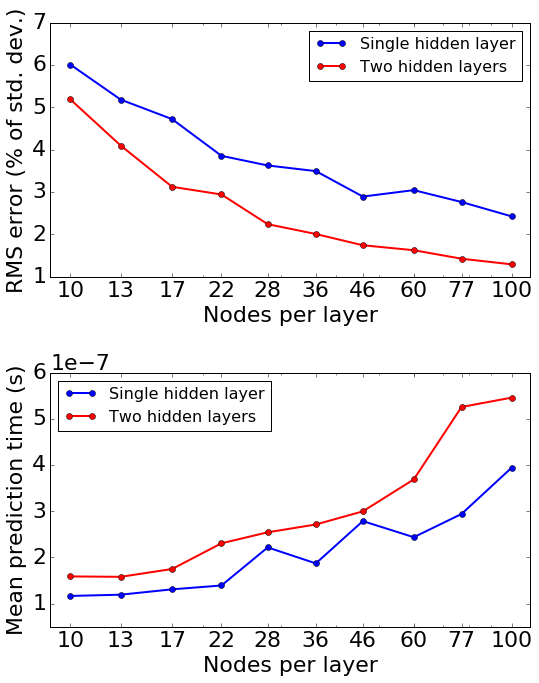

In [58]:
font = {'family': 'normal',
        'weight': 'normal',
        'size': 22}

plt.rc('font', **font)


nrows = 2
ncols = 1
nplot = nrows * ncols

plt.clf()
fig, axes = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(8,10)
# ax_time_train, ax_time_pred, ax_pred_err = axes.flat
ax_pred_err,ax_time_pred = axes.flat

# # Training time
# ax_time_train.set_ylabel("Mean training time (s)")
# ax_time_train.set_yscale('log')
# ax_time_train.set_xscale("log")
# ax_time_train.plot(numNodes, avg_train_time_1, 'bo-', lw=2, label = "Single hidden layer")
# ax_time_train.plot(numNodes, avg_train_time, 'ro-', lw=2, label = "Two hidden layers")
# ax_time_train.legend(loc=2, fontsize=16)
# ax_time_train.set_xticks(numNodes)
# ax_time_train.set_xticklabels(numNodes)
# ax_time_train.set_xlim((numNodes[0]*(1-0.1),numNodes[-1]*(1+0.1)))
# ax_time_train.set_ylim((8e-5,2e-3))

# Prediction error
# ax_pred_err.set_yscale("log")
ax_pred_err.set_xscale("log")
ax_pred_err.set_ylabel("RMS error (% of std. dev.)")
ax_pred_err.set_xlabel("Nodes per layer")
ax_pred_err.plot(numNodes, np.asarray(avg_pred_err_1)*100, 'bo-', lw=2, label = "Single hidden layer")
ax_pred_err.plot(numNodes, np.asarray(avg_pred_err)*100, 'ro-', lw=2, label = "Two hidden layers")
ax_pred_err.legend(loc=1, fontsize=16)
ax_pred_err.set_xticks(numNodes)
ax_pred_err.set_xticklabels(numNodes)
ax_pred_err.set_xlim((numNodes[0]*(1-0.1),numNodes[-1]*(1+0.1)))
ax_pred_err.set_ylim(1,7)


# Prediction time
# ax_time_pred.set_yscale("log")
ax_time_pred.set_xscale("log")
ax_time_pred.set_xlabel("Nodes per layer")
ax_time_pred.set_ylabel("Mean prediction time (s)")
ax_time_pred.plot(numNodes, avg_pred_time_1, 'bo-', lw=2, label = "Single hidden layer")
ax_time_pred.plot(numNodes, avg_pred_time, 'ro-', lw=2, label = "Two hidden layers")
# ax_time_pred.axhline(y=1.6e-5, lw=2, ls='dashed', color='k', label= "Schr. Eqn.")
ax_time_pred.set_ylim((1e-7,3e-5))
ax_time_pred.legend(loc=2, fontsize=16)
ax_time_pred.set_xticks(numNodes)
ax_time_pred.set_xticklabels(numNodes)
ax_time_pred.set_xlim((numNodes[0]*(1-0.1),numNodes[-1]*(1+0.1)))
ax_time_pred.set_ylim((5e-8,6e-7))



plt.tight_layout();
plt.show();
plt.draw()
fig.savefig("../Presentation/Plots/archDep.png")

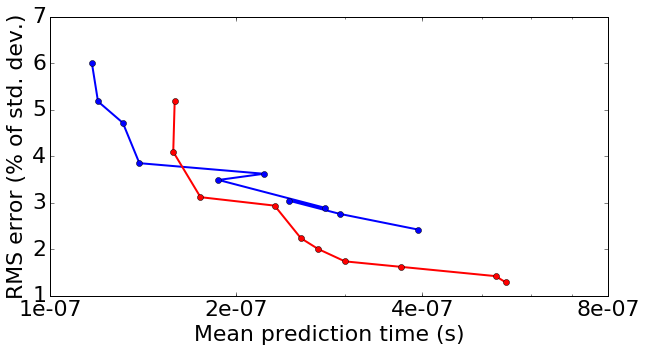

In [26]:
plt.clf()
plt.figure(figsize=(10,5))

# Set up the axes
ax = plt.axes()
ax.set_xscale('log')
ax.set_xlabel('Mean prediction time (s)')
ax.set_ylabel('RMS error (% of std. dev.)')
ax.set_xlim((1e-7,8e-7))
ax.set_xticks([1e-7,2e-7,4e-7,8e-7])
ax.set_xticklabels([1e-7,2e-7,4e-7,8e-7])

# Draw the points
plt.plot(avg_pred_time_1, np.asarray(avg_pred_err_1)*100, 'bo-',lw=2, label='Single hidden layer')
plt.plot(avg_pred_time, np.asarray(avg_pred_err)*100, 'ro-', lw=2, label='Two hidden layer')

# plt.tight_layout();
plt.show();
plt.draw()
#fig.savefig("../Plots/NNPred.png")